# Panorama da desigualdade de gênero no mercado de Inteligência Artificial no Brasil

## Prof. Dr. Neylson Crepalde

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import matplotlib.pyplot as plt
import seaborn as sns
from deflatebr import deflate

In [2]:
sud = pd.read_csv("../data/processed/rais_2008_2018.csv", sep='\t')
sud

C:\Users\Neylson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (6,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Ano,CNAE 2.0 Classe,Escolaridade após 2005,Qtd Hora Contr,Idade,Ind Simples,Mun Trab,Município,Nacionalidade,Brasileiro,...,Vl Remun Média Nom,Vl Remun Média (SM),CNAE 2.0 Subclasse,Sexo Trabalhador,Tamanho Estabelecimento,Tempo Emprego,Tipo Admissão,Tipo Defic,Tipo Salário,Tipo Vínculo
0,2008,62015.0,1.0,44.0,21.0,0.0,0000-1,320530.0,10.0,1,...,1232.62,2.96,6201500.0,Masculino,4.0,4.7,2.0,0.0,NaN,10.0
1,2008,62015.0,1.0,44.0,23.0,0.0,0000-1,320530.0,10.0,1,...,1173.30,2.82,6201500.0,Masculino,4.0,2.3,1.0,0.0,NaN,10.0
2,2008,62031.0,2.0,44.0,34.0,0.0,0000-1,320530.0,10.0,1,...,1800.00,4.44,6203100.0,Masculino,5.0,77.9,0.0,0.0,NaN,10.0
3,2008,62040.0,3.0,44.0,50.0,0.0,320060,320060.0,10.0,1,...,7266.49,19.11,6204000.0,Masculino,5.0,0.3,2.0,0.0,NaN,10.0
4,2008,62040.0,4.0,44.0,49.0,0.0,320060,320060.0,10.0,1,...,1019.76,2.45,6204000.0,Masculino,5.0,0.1,2.0,0.0,NaN,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306533,2017,62015.0,10.0,40.0,54.0,0.0,355030,355030.0,10.0,1,...,9860.01,10.52,6201501.0,Feminino,10.0,8.9,2.0,0.0,NaN,10.0
2306534,2017,62040.0,10.0,40.0,41.0,0.0,0,355030.0,10.0,1,...,2799.10,2.98,6204000.0,Feminino,4.0,5.9,2.0,0.0,NaN,10.0
2306535,2017,62015.0,10.0,40.0,35.0,0.0,355030,355030.0,10.0,1,...,6306.81,6.72,6201501.0,Feminino,10.0,23.6,0.0,0.0,NaN,10.0
2306536,2017,62015.0,10.0,40.0,32.0,0.0,0,350570.0,27.0,0,...,1142.85,1.21,6201501.0,Feminino,7.0,6.3,1.0,0.0,NaN,10.0


In [3]:
sud.columns

Index(['Ano', 'CNAE 2.0 Classe', 'Escolaridade após 2005', 'Qtd Hora Contr',
       'Idade', 'Ind Simples', 'Mun Trab', 'Município', 'Nacionalidade',
       'Brasileiro', 'Natureza Jurídica', 'Ind Portador Defic',
       'Qtd Dias Afastamento', 'Raça Cor', 'Regiões Adm DF',
       'Vl Remun Dezembro Nom', 'Vl Remun Dezembro (SM)', 'Vl Remun Média Nom',
       'Vl Remun Média (SM)', 'CNAE 2.0 Subclasse', 'Sexo Trabalhador',
       'Tamanho Estabelecimento', 'Tempo Emprego', 'Tipo Admissão',
       'Tipo Defic', 'Tipo Salário', 'Tipo Vínculo'],
      dtype='object')

In [3]:
print(sud.shape)
sud.describe(include="all").transpose()

(2306538, 27)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Ano,2.30654e+06,NaN,NaN,NaN,2013.46,3.02507,2008,2011,2014,2016,2018
CNAE 2.0 Classe,2.30654e+06,NaN,NaN,NaN,62027.3,10.9053,62015,62015,62031,62040,62040
Escolaridade após 2005,2.30654e+06,NaN,NaN,NaN,7.29578,1.06575,0,6,8,8,10
Qtd Hora Contr,2.30654e+06,NaN,NaN,NaN,40.5478,5.03444,1,40,40,44,44
Idade,2.30654e+06,NaN,NaN,NaN,32.584,9.53904,18,26,30,37,80
Ind Simples,2.30654e+06,NaN,NaN,NaN,0.063281,0.243468,0,0,0,0,1
Mun Trab,2.30654e+06,1235,355030,587693,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Município,2.30654e+06,NaN,NaN,NaN,344058,15727.5,310010,330455,354340,355030,355730
Nacionalidade,2.30654e+06,NaN,NaN,NaN,10.1947,2.60638,10,10,10,10,80
Brasileiro,2.30654e+06,NaN,NaN,NaN,0.992859,0.0841997,0,1,1,1,1


In [4]:
print(sud['Escolaridade após 2005'].unique())
sud['Escolaridade após 2005'].value_counts()

[ 1.  2.  3.  4.  5.  6.  7.  8.  9.  0. 10.]


8.0     1389010
6.0      506168
7.0      308677
5.0       31581
4.0       27126
9.0       18274
3.0       16086
2.0        4306
10.0       2813
1.0        2295
0.0         202
Name: Escolaridade após 2005, dtype: int64

In [5]:
sud['Sexo Trabalhador'].value_counts()

Masculino    1499793
Feminino      806745
Name: Sexo Trabalhador, dtype: int64

In [6]:
sud['Raça Cor'].value_counts()

Branca              1583407
Parda                467188
Não identificada     131076
Preta                 85997
Amarela               32415
Indígena               6363
Name: Raça Cor, dtype: int64

In [7]:
sud.Brasileiro.value_counts()

1    2290068
0      16470
Name: Brasileiro, dtype: int64

Muito pouco estrangeiro trabalhando na área. Talvez não seja uma variável interessante para modelar.

In [8]:
sud.groupby("Brasileiro").agg({"Vl Remun Média Nom": "median"})

,Vl Remun Média Nom
Brasileiro,
0,6298.29
1,2500.00


Mas a diferença salarial é gritante! Investiguemos.

In [9]:
sud['Tempo Emprego']

0           4.7
1           2.3
2          77.9
3           0.3
4           0.1
           ... 
2306533     8.9
2306534     5.9
2306535    23.6
2306536     6.3
2306537     9.7
Name: Tempo Emprego, Length: 2306538, dtype: float64

In [10]:
sud.shape

(2306538, 27)

In [11]:
sud.columns

Index(['Ano', 'CNAE 2.0 Classe', 'Escolaridade após 2005', 'Qtd Hora Contr',
       'Idade', 'Ind Simples', 'Mun Trab', 'Município', 'Nacionalidade',
       'Brasileiro', 'Natureza Jurídica', 'Ind Portador Defic',
       'Qtd Dias Afastamento', 'Raça Cor', 'Regiões Adm DF',
       'Vl Remun Dezembro Nom', 'Vl Remun Dezembro (SM)', 'Vl Remun Média Nom',
       'Vl Remun Média (SM)', 'CNAE 2.0 Subclasse', 'Sexo Trabalhador',
       'Tamanho Estabelecimento', 'Tempo Emprego', 'Tipo Admissão',
       'Tipo Defic', 'Tipo Salário', 'Tipo Vínculo'],
      dtype='object')

#### Variáveis de interesse para trabalhar

- Sexo Trabalhador
- Idade
- Qtd Hora Contrat
- Escolaridade após 2005
- Município
- Nacionalidade
- Raça Cor
- Vl Remun Dezembro Nom
- Vl Remun Média Nom
- Tamanho Estabelecimento
- Tempo Emprego (em meses)
- Brasileiro

Verificar as categorias das variáveis e implementar cosntrução de labels.

---

# Análise Exploratória de Dados

## Sexo

Existem diferenças significativas nas principais variáveis elencadas por sexo?

Masculino    1499793
Feminino      806745
Name: Sexo Trabalhador, dtype: int64
Masculino    65.02
Feminino     34.98
Name: Sexo Trabalhador, dtype: float64


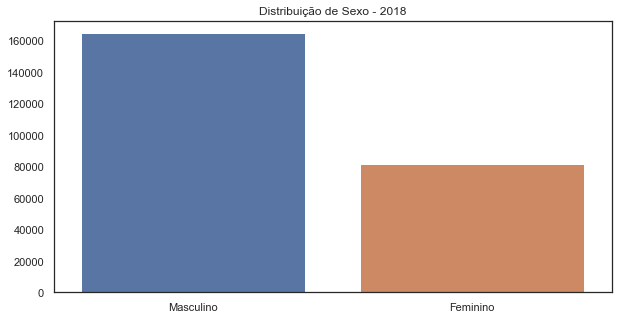

In [10]:
print(sud['Sexo Trabalhador'].value_counts())
print(((sud['Sexo Trabalhador'].value_counts() / sud.shape[0] )*100).round(2))

# Gráfico
sns.set(style="white")

plt.figure(figsize=(10,5))
sns.countplot(sud.loc[sud.Ano == 2018,'Sexo Trabalhador'])
plt.title("Distribuição de Sexo - 2018")
plt.ylabel("")
plt.xlabel("")
plt.xticks([0,1],["Masculino", "Feminino"])
plt.show()

In [12]:
dist_sexom = []
dist_sexof = []
for ano in range(2008, 2019):
    dist_sexom.append(sud.loc[(sud.Ano == ano), 'Sexo Trabalhador'].value_counts()[0])
    dist_sexof.append(sud.loc[(sud.Ano == ano), 'Sexo Trabalhador'].value_counts()[1])

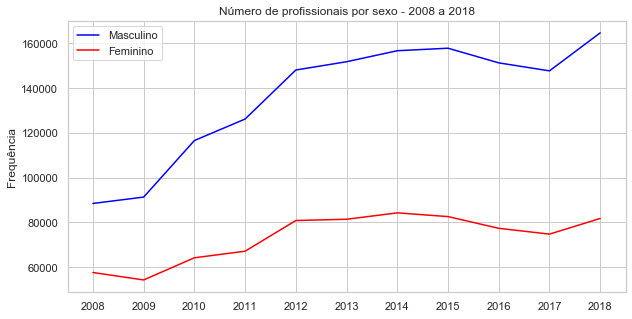

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,5))
plt.plot(np.array(list(range(2008, 2019))), dist_sexom, c='blue', label='Masculino')
plt.plot(np.array(list(range(2008, 2019))), dist_sexof, c='red', label='Feminino')
plt.title("Número de profissionais por sexo - 2008 a 2018")
plt.ylabel("Frequência")
plt.legend()
plt.xticks(np.array(list(range(2008, 2019))))
plt.show()

In [14]:
prop_sexom = []
prop_sexof = []
for ano in range(2008, 2019):
    prop_sexom.append((sud.loc[(sud.Ano == ano), 'Sexo Trabalhador'].value_counts()[0] / sud.loc[(sud.Ano == ano), 'Sexo Trabalhador'].value_counts().sum())*100)
    prop_sexof.append((sud.loc[(sud.Ano == ano), 'Sexo Trabalhador'].value_counts()[1] / sud.loc[(sud.Ano == ano), 'Sexo Trabalhador'].value_counts().sum())*100)

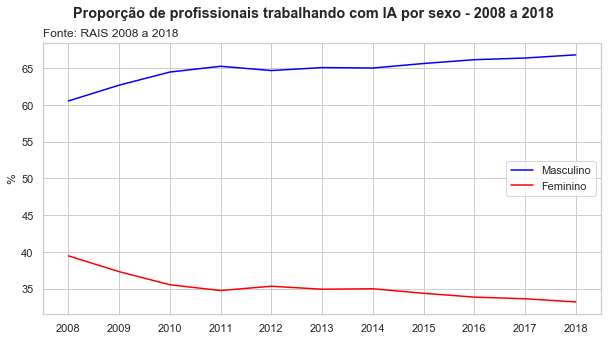

In [15]:
plt.figure(figsize=(10,5))
plt.plot(np.array(list(range(2008, 2019))), prop_sexom, c='blue', label='Masculino')
plt.plot(np.array(list(range(2008, 2019))), prop_sexof, c='red', label='Feminino')
plt.suptitle("Proporção de profissionais trabalhando com IA por sexo - 2008 a 2018", fontweight="bold", fontsize="large")
plt.title("Fonte: RAIS 2008 a 2018", loc='left')
plt.ylabel("%")
plt.legend()
plt.xticks(np.array(list(range(2008, 2019))))
#plt.ylim((0,100))
plt.show()

## Idade

In [17]:
sud.loc[sud.Ano == 2018,"Idade"].describe()

count    246355.000000
mean         33.831077
std           9.568180
min          18.000000
25%          27.000000
50%          32.000000
75%          39.000000
max          80.000000
Name: Idade, dtype: float64

In [18]:
sud.loc[sud.Ano == 2018,:].groupby("Sexo Trabalhador").agg({"Idade": "mean"})

,Idade
Sexo Trabalhador,
Feminino,33.536469
Masculino,33.977516


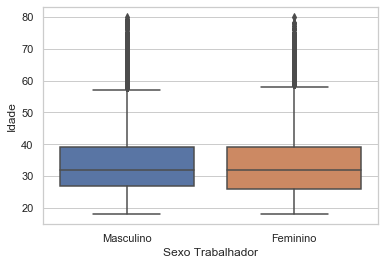

In [19]:
sns.boxplot(x="Sexo Trabalhador", y="Idade", data=sud.loc[sud.Ano == 2018,:])
plt.show()

In [20]:
stats.ttest_ind(sud.loc[(sud["Sexo Trabalhador"] == "Masculino") & (sud.Ano == 2018),"Idade"], 
                sud.loc[(sud["Sexo Trabalhador"] == "Feminino") & (sud.Ano == 2018),"Idade"])

Ttest_indResult(statistic=10.77712897706621, pvalue=4.476375552602861e-27)

Embora o teste T tenha dado significativo, há razões para desconfiar que o baixo p-valor se deve apenas ao fato de o $n$ ser enorme. Se o $n$ fosse menor, provavelmente essas diferenças não seriam significativas. Vamos testar com 5 mil casos aleatórios e bootstrap.

In [21]:
pvalores = []
for i in range(1000):
    res = stats.ttest_ind(sud.loc[(sud["Sexo Trabalhador"] == "Masculino") & (sud.Ano == 2018),"Idade"].sample(n=10000), 
                          sud.loc[(sud["Sexo Trabalhador"] == "Masculino") & (sud.Ano == 2018),"Idade"].sample(n=5000))
    pvalores.append(res.pvalue)
print("Média dos p-valores: ", np.mean(pvalores).round(4))

Média dos p-valores:  0.5157


In [ ]:
# Médias de Idade no tempo

## Raça Cor

In [21]:
t = pd.crosstab(sud.loc[sud.Ano == 2018,'Sexo Trabalhador'], sud.loc[sud.Ano == 2018,'Raça Cor'])
t.apply(lambda r: (r/r.sum()*100), axis=1)

Raça Cor,Amarela,Branca,Indígena,Não identificada,Parda,Preta
Sexo Trabalhador,,,,,,
Feminino,1.617439,63.466429,0.293413,8.491858,21.543841,4.587021
Masculino,1.505235,64.070637,0.264951,8.456541,21.700424,4.002212


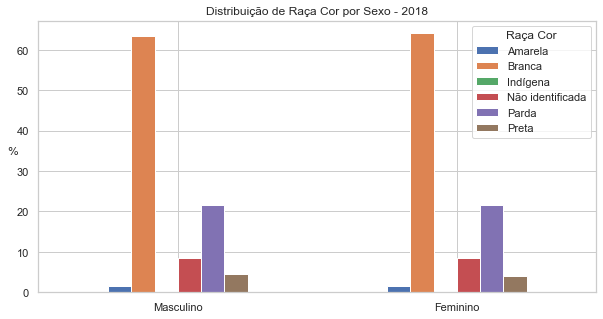

In [22]:
sns.set(style="whitegrid")
t.apply(lambda r: (r/r.sum()*100), axis=1).plot(kind="bar", figsize=(10,5))
plt.xticks([0,1], ['Masculino', 'Feminino'], rotation=0)
plt.xlabel("")
plt.ylabel("%", rotation=0)
plt.title("Distribuição de Raça Cor por Sexo - 2018")
plt.show()

In [40]:
print(t)
stats.chi2_contingency(t)

Raça Cor          Amarela  Branca  Indígena  Não identificada  Parda  Preta
Sexo Trabalhador                                                           
Feminino             1323   51913       240              6946  17622   3752
Masculino            2477  105434       436             13916  35710   6586


(54.42405595521234,
 1.714683446183853e-10,
 5,
 array([[  1261.69470886,  52243.12561953,    224.44884821,
           6926.70395161,  17707.55321386,   3432.47365793],
        [  2538.30529114, 105103.87438047,    451.55115179,
          13935.29604839,  35624.44678614,   6905.52634207]]))

Muito embora o teste $\chi^2$ tenha dado significativo, ao observamos a tabela de valores observados e os valores esperados abaixo, vemos que eles estão bastante próximos. Poderíamos indagar se o $n$ fosse menor, esses valores não seriam significativos. Provavelmente não...

In [25]:
pvalores_chi2 = []
for i in range(1000):
    subamostra = sud.loc[sud.Ano == 2018,:].sample(5000)
    t1 = pd.crosstab(subamostra['Sexo Trabalhador'], subamostra['Raça Cor'])
    pvalores_chi2.append(stats.chi2_contingency(t1)[1])
print("Média de p-valores chi2 para sexo e raça:", np.mean(pvalores_chi2).round(4))

Média de p-valores chi2 para sexo e raça: 0.3923


Utilizando bootstrap, o $\chi^2$ não fica significativo.

---

In [41]:
stats.ttest_ind(sud.loc[(sud["Sexo Trabalhador"] == "Masculino") & (sud.Ano == 2018),"Qtd Hora Contr"],
                        sud.loc[(sud["Sexo Trabalhador"] == "Feminino") & (sud.Ano == 2018),"Qtd Hora Contr"])

Ttest_indResult(statistic=23.169395576468037, pvalue=1.2426217854006772e-118)

In [43]:
# Testa diferenças nas horas de contrato usando bootstrap
pvalores_qtdhoracont = []
for i in range(1000):
    res = stats.ttest_ind(sud.loc[(sud["Sexo Trabalhador"] == "Masculino") & (sud.Ano == 2018),"Qtd Hora Contr"].sample(n=10000),
                          sud.loc[(sud["Sexo Trabalhador"] == "Feminino") & (sud.Ano == 2018),"Qtd Hora Contr"].sample(n=5000))
    pvalores_qtdhoracont.append(res.pvalue)
print("Média dos p-valores para Qtd Hora Contr:", np.mean(pvalores_qtdhoracont).round(4))

Média dos p-valores para Qtd Hora Contr: 0.0001


In [5]:
ddd = sud.groupby(["Ano", "Sexo Trabalhador"]).agg({"Vl Remun Média Nom": "median", 
                                     "Qtd Hora Contr": "mean",
                                     "Escolaridade após 2005": "mean",
                                     "Tempo Emprego": "median"
                                    }).reset_index()
ddd.loc[ddd['Sexo Trabalhador'] == 'Masculino',:]

,Ano,Sexo Trabalhador,Vl Remun Média Nom,Qtd Hora Contr,Escolaridade após 2005,Tempo Emprego
1,2008,Masculino,1630.740,41.810856,6.842117,10.7
3,2009,Masculino,1928.425,42.015594,7.131497,11.9
5,2010,Masculino,1900.800,42.333273,7.226032,11.3
7,2011,Masculino,2215.060,41.947421,7.253288,12.5
9,2012,Masculino,2348.640,41.262517,7.278653,12.9
11,2013,Masculino,2833.355,40.499064,7.429470,15.5
13,2014,Masculino,3085.970,40.199681,7.464672,15.9
15,2015,Masculino,3469.200,40.045082,7.507881,17.9
17,2016,Masculino,3765.260,39.966575,7.542795,20.6
19,2017,Masculino,4143.380,39.969880,7.574324,21.0


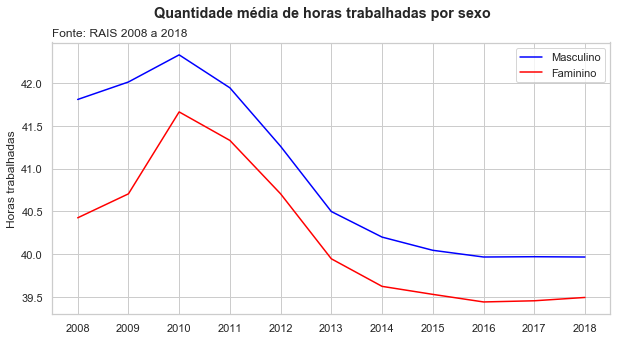

In [17]:
# Qtd Hora Contr longitudinal
datas = ['2008-12-01', '2009-12-01', '2010-12-01', '2011-12-01', '2012-12-01',
        '2013-12-01', '2014-12-01', '2015-12-01', '2016-12-01', '2017-12-01', '2018-12-01']
plt.figure(figsize=(10,5))
plt.plot(list(range(2008, 2019)), ddd.loc[ddd["Sexo Trabalhador"] == "Masculino", "Qtd Hora Contr"], label='Masculino', c='blue')
plt.plot(list(range(2008, 2019)), ddd.loc[ddd["Sexo Trabalhador"] == "Feminino", "Qtd Hora Contr"], label='Faminino', c='red')
plt.xticks(np.array(range(2008, 2019)))
plt.suptitle("Quantidade média de horas trabalhadas por sexo", fontweight="bold", fontsize="large")
plt.title("Fonte: RAIS 2008 a 2018", loc='left')
plt.ylabel("Horas trabalhadas")
plt.legend()
plt.show()

In [18]:
# Testa diferenças de escolaridade usando bootstrap
pvalores_esco = []
for i in range(1000):
    res = stats.ttest_ind(sud.loc[(sud["Sexo Trabalhador"] == "Masculino") & (sud.Ano == 2018),"Escolaridade após 2005"].sample(n=10000),
                          sud.loc[(sud["Sexo Trabalhador"] == "Feminino") & (sud.Ano == 2018),"Escolaridade após 2005"].sample(n=5000))
    pvalores_esco.append(res.pvalue)
print("Média dos p-valores para Escolaridade:", np.mean(pvalores_esco).round(4))

Média dos p-valores para Escolaridade: 0.0


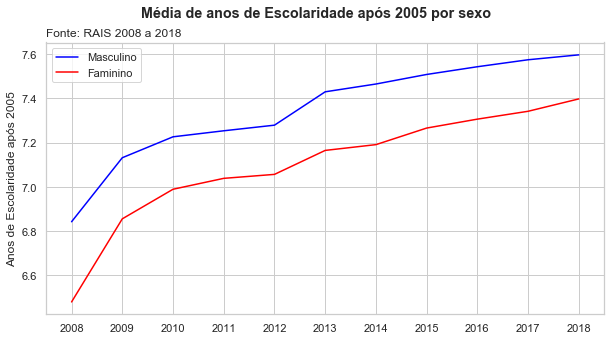

In [23]:
# Escolaridade após 2005
plt.figure(figsize=(10,5))
plt.plot(list(range(2008, 2019)), ddd.loc[ddd["Sexo Trabalhador"] == "Masculino", "Escolaridade após 2005"], label='Masculino', c='blue')
plt.plot(list(range(2008, 2019)), ddd.loc[ddd["Sexo Trabalhador"] == "Feminino", "Escolaridade após 2005"], label='Faminino', c='red')
plt.xticks(np.array(range(2008, 2019)))
plt.suptitle("Média de anos de Escolaridade após 2005 por sexo", fontweight="bold", fontsize="large")
plt.title("Fonte: RAIS 2008 a 2018", loc='left')
plt.ylabel("Anos de Escolaridade após 2005")
plt.legend()
plt.show()

In [52]:
# Testa diferenças de tempo de emprego usando bootstrap
pvalores_tempoemprego = []
for i in range(1000):
    res = stats.ttest_ind(sud.loc[(sud["Sexo Trabalhador"] == "Masculino") & (sud.Ano == 2018),"Tempo Emprego"].sample(n=10000),
                          sud.loc[(sud["Sexo Trabalhador"] == "Feminino") & (sud.Ano == 2018),"Tempo Emprego"].sample(n=5000))
    pvalores_tempoemprego.append(res.pvalue)
print("Média dos p-valores para Tempo de Emprego:", np.mean(pvalores_tempoemprego).round(4))

Média dos p-valores para Tempo de Emprego: 0.0403


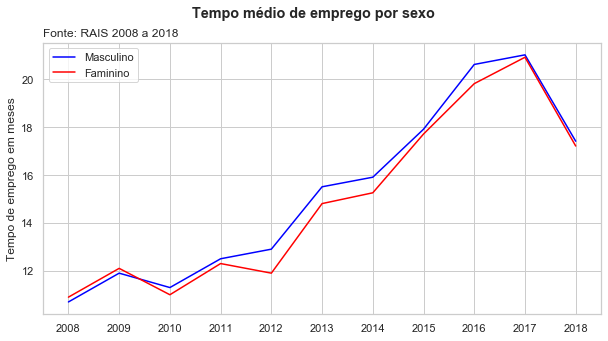

In [20]:
# Tempo médio de emprego
plt.figure(figsize=(10,5))
plt.plot(list(range(2008, 2019)), ddd.loc[ddd["Sexo Trabalhador"] == "Masculino", "Tempo Emprego"], label='Masculino', c='blue')
plt.plot(list(range(2008, 2019)), ddd.loc[ddd["Sexo Trabalhador"] == "Feminino", "Tempo Emprego"], label='Faminino', c='red')
plt.xticks(np.array(range(2008, 2019)))
plt.suptitle("Tempo médio de emprego por sexo", fontweight="bold", fontsize="large")
plt.title("Fonte: RAIS 2008 a 2018", loc='left')
plt.ylabel("Tempo de emprego em meses")
plt.legend()
plt.show()

In [54]:
# Testa diferenças de salário usando bootstrap
pvalores_sal = []
for i in range(1000):
    res = stats.ttest_ind(sud.loc[(sud["Sexo Trabalhador"] == "Masculino") & (sud.Ano == 2018),"Vl Remun Média Nom"].sample(n=10000),
                          sud.loc[(sud["Sexo Trabalhador"] == "Feminino") & (sud.Ano == 2018),"Vl Remun Média Nom"].sample(n=5000))
    pvalores_sal.append(res.pvalue)
print("Média dos p-valores para Salário médio:", np.mean(pvalores_sal).round(4))

Média dos p-valores para Salário médio: 0.0


É possível afirmar que as mulheres trabalham sistematicamente menos, possuem escolaridade mais baixa e possuem salário sistematicamente menor.

---

# Investigando a diferença de salário

In [3]:
med_salario = sud.groupby(["Ano","Sexo Trabalhador"]).agg({"Vl Remun Média Nom": "mean"}).reset_index()
med_salario

,Ano,Sexo Trabalhador,Vl Remun Média Nom
0,2008,Feminino,1936.964426
1,2008,Masculino,2901.688360
2,2009,Feminino,2291.503450
3,2009,Masculino,3283.430501
4,2010,Feminino,2419.342795
5,2010,Masculino,3320.918128
6,2011,Feminino,2709.993539
7,2011,Masculino,3688.054052
8,2012,Feminino,2833.185241
9,2012,Masculino,3965.154136


In [6]:
datas = ['2008-12-01', '2009-12-01', '2010-12-01', '2011-12-01', '2012-12-01',
        '2013-12-01', '2014-12-01', '2015-12-01', '2016-12-01', '2017-12-01', '2018-12-01']
sal_m = deflate(ddd.loc[ddd['Sexo Trabalhador'] == 'Masculino', 'Vl Remun Média Nom'], datas, '2020-01')
sal_f = deflate(ddd.loc[ddd['Sexo Trabalhador'] == 'Feminino', 'Vl Remun Média Nom'], datas, '2020-01')

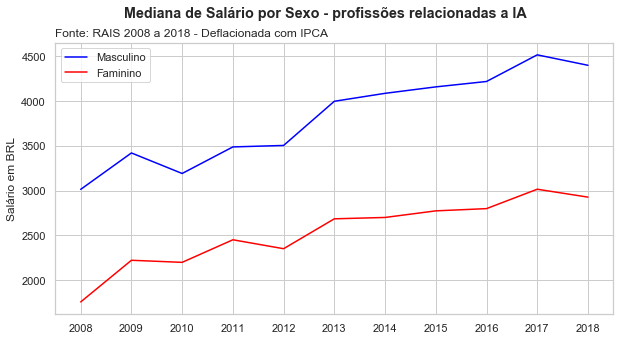

In [8]:
sns.set(style='whitegrid')
plt.figure(figsize=(10,5))
plt.plot(list(range(2008, 2019)), sal_m, label='Masculino', c='blue')
plt.plot(list(range(2008, 2019)), sal_f, label='Faminino', c='red')
plt.xticks(np.array(range(2008, 2019)))
plt.suptitle("Mediana de Salário por Sexo - profissões relacionadas a IA", fontweight="bold", fontsize="large")
plt.title("Fonte: RAIS 2008 a 2018 - Deflacionada com IPCA", loc='left')
plt.ylabel("Salário em BRL")
plt.legend()
plt.show()

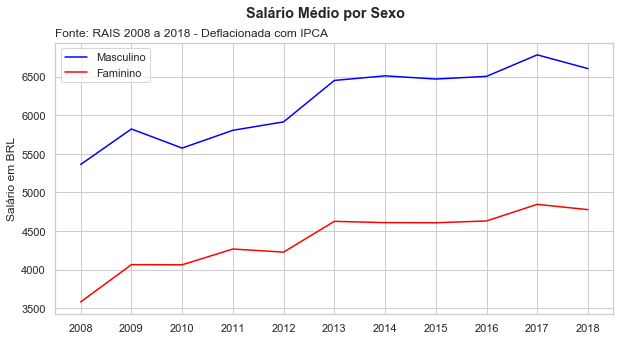

In [24]:
salmed_m = deflate(med_salario.loc[med_salario['Sexo Trabalhador'] == 'Masculino', 'Vl Remun Média Nom'], datas, '2020-01')
salmed_f = deflate(med_salario.loc[med_salario['Sexo Trabalhador'] == 'Feminino', 'Vl Remun Média Nom'], datas, '2020-01')
plt.figure(figsize=(10,5))
plt.plot(list(range(2008, 2019)), salmed_m, label='Masculino', c='blue')
plt.plot(list(range(2008, 2019)), salmed_f, label='Faminino', c='red')
plt.xticks(np.array(range(2008, 2019)))
plt.suptitle("Salário Médio por Sexo", fontweight="bold", fontsize="large")
plt.title("Fonte: RAIS 2008 a 2018 - Deflacionada com IPCA", loc='left')
plt.ylabel("Salário em BRL")
plt.legend()
plt.show()

In [25]:
# Foram filtrados os salários == 0
sud.loc[sud["Vl Remun Média Nom"] == 0,'Vl Remun Média Nom'].sum()

0.0

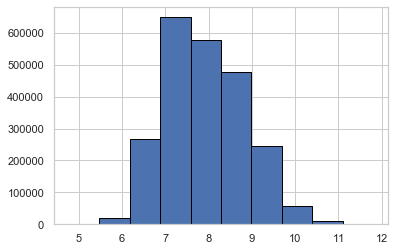

In [26]:
plt.hist(np.log(sud['Vl Remun Média Nom']), edgecolor="black")
plt.show()

Vamos modelar apenas as pessoas que recebem algum tipo de salário.

In [27]:
sud.columns

Index(['Ano', 'CNAE 2.0 Classe', 'Escolaridade após 2005', 'Qtd Hora Contr',
       'Idade', 'Ind Simples', 'Mun Trab', 'Município', 'Nacionalidade',
       'Brasileiro', 'Natureza Jurídica', 'Ind Portador Defic',
       'Qtd Dias Afastamento', 'Raça Cor', 'Regiões Adm DF',
       'Vl Remun Dezembro Nom', 'Vl Remun Dezembro (SM)', 'Vl Remun Média Nom',
       'Vl Remun Média (SM)', 'CNAE 2.0 Subclasse', 'Sexo Trabalhador',
       'Tamanho Estabelecimento', 'Tempo Emprego', 'Tipo Admissão',
       'Tipo Defic', 'Tipo Salário', 'Tipo Vínculo'],
      dtype='object')

In [3]:
sud['idadecent'] = sud.Idade - np.mean(sud.Idade)
sud['Idade_quad'] = sud.idadecent ** 2

In [4]:
# Cria dummy branco
sud["Branco"] = sud['Raça Cor'].apply(lambda x: 1 if x in ['Branca', 'Amarela'] else 0)

In [30]:
pd.crosstab(sud.Branco, sud["Raça Cor"])

Raça Cor,Amarela,Branca,Indígena,Não identificada,Parda,Preta
Branco,,,,,,
0,0,0,6363,131076,467188,85997
1,32415,1583407,0,0,0,0


In [31]:
sud.columns

Index(['Ano', 'CNAE 2.0 Classe', 'Escolaridade após 2005', 'Qtd Hora Contr',
       'Idade', 'Ind Simples', 'Mun Trab', 'Município', 'Nacionalidade',
       'Brasileiro', 'Natureza Jurídica', 'Ind Portador Defic',
       'Qtd Dias Afastamento', 'Raça Cor', 'Regiões Adm DF',
       'Vl Remun Dezembro Nom', 'Vl Remun Dezembro (SM)', 'Vl Remun Média Nom',
       'Vl Remun Média (SM)', 'CNAE 2.0 Subclasse', 'Sexo Trabalhador',
       'Tamanho Estabelecimento', 'Tempo Emprego', 'Tipo Admissão',
       'Tipo Defic', 'Tipo Salário', 'Tipo Vínculo', 'idadecent', 'Idade_quad',
       'Branco'],
      dtype='object')

---

## Modelagem


In [5]:
sud['Ano'] = sud['Ano'].astype('object')

In [6]:
X = pd.get_dummies(sud[['Sexo Trabalhador',
                       'Escolaridade após 2005', 
                       'Qtd Hora Contr', 
                       'idadecent', 'Idade_quad', 
                       'Brasileiro', 
                       'Branco', 
                       'Tempo Emprego',
                       'Ano'
                      ]],
                  drop_first=True)

In [7]:
from datetime import timedelta
# Deflaciona salário
salarios = sud[['Ano', 'Vl Remun Média Nom']]
salarios['Ano'] = pd.to_datetime(salarios.Ano, format="%Y")
salarios['Ano'] = salarios.Ano + timedelta(days=330)
salarios['Ano'] = salarios['Ano'].apply(lambda x: x.replace(day=1))
salarios['Ano'] = salarios.Ano.dt.date.astype(str)
salarios


C:\Users\Neylson\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Neylson\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Neylson\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,Ano,Vl Remun Média Nom
0,2008-11-01,1232.62
1,2008-11-01,1173.30
2,2008-11-01,1800.00
3,2008-11-01,7266.49
4,2008-11-01,1019.76
...,...,...
2306533,2017-11-01,9860.01
2306534,2017-11-01,2799.10
2306535,2017-11-01,6306.81
2306536,2017-11-01,1142.85


In [8]:
salarios['deflacionado'] = deflate(nominal_dates=salarios.Ano, nominal_values=salarios['Vl Remun Média Nom'], real_date='2020-01',
                                  progress_bar=True, on_jupyter=True)
salarios

C:\Users\Neylson\Anaconda3\lib\site-packages\tqdm\std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


C:\Users\Neylson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Ano,Vl Remun Média Nom,deflacionado
0,2008-11-01,1232.62,2286.232373
1,2008-11-01,1173.30,2176.207139
2,2008-11-01,1800.00,3338.594434
3,2008-11-01,7266.49,13477.701706
4,2008-11-01,1019.76,1891.425034
...,...,...,...
2306533,2017-11-01,9860.01,10769.342794
2306534,2017-11-01,2799.10,3057.245116
2306535,2017-11-01,6306.81,6888.451313
2306536,2017-11-01,1142.85,1248.248573


In [9]:
y = np.log(salarios.deflacionado)

In [10]:
X = add_constant(X)
X

C:\Users\Neylson\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,Escolaridade após 2005,Qtd Hora Contr,idadecent,Idade_quad,Brasileiro,Branco,Tempo Emprego,Sexo Trabalhador_Masculino,Ano_2009,Ano_2010,Ano_2011,Ano_2012,Ano_2013,Ano_2014,Ano_2015,Ano_2016,Ano_2017,Ano_2018
0,1.0,1.0,44.0,-11.583958,134.188080,1,0,4.7,1,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,44.0,-9.583958,91.852248,1,0,2.3,1,0,0,0,0,0,0,0,0,0,0
2,1.0,2.0,44.0,1.416042,2.005175,1,0,77.9,1,0,0,0,0,0,0,0,0,0,0
3,1.0,3.0,44.0,17.416042,303.318524,1,0,0.3,1,0,0,0,0,0,0,0,0,0,0
4,1.0,4.0,44.0,16.416042,269.486439,1,1,0.1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306533,1.0,10.0,40.0,21.416042,458.646861,1,1,8.9,0,0,0,0,0,0,0,0,0,1,0
2306534,1.0,10.0,40.0,8.416042,70.829765,1,0,5.9,0,0,0,0,0,0,0,0,0,1,0
2306535,1.0,10.0,40.0,2.416042,5.837260,1,1,23.6,0,0,0,0,0,0,0,0,0,1,0
2306536,1.0,10.0,40.0,-0.583958,0.341007,0,1,6.3,0,0,0,0,0,0,0,0,0,1,0


### Teste de multicolinearidade

In [112]:
for col in X.columns:
    print(col + ": ", vif(X.values, X.columns.get_loc(col)))

const:  293.0130813246426
Escolaridade após 2005:  1.142430778024399
Qtd Hora Contr:  1.2162289512587046
idadecent:  1.8341047551652745
Idade_quad:  1.7441398201969418
Brasileiro:  1.0057330483414957
Branco:  1.0366192092447886
Tempo Emprego:  1.3782687459023062
Sexo Trabalhador_Masculino:  1.018168063906884
Ano_2009:  1.8767806339386877
Ano_2010:  2.076176981105023
Ano_2011:  2.145437825391867
Ano_2012:  2.33346191292951
Ano_2013:  2.3730276934947865
Ano_2014:  2.420702822139912
Ano_2015:  2.427072106436258
Ano_2016:  2.3722569335661707
Ano_2017:  2.345820562407771
Ano_2018:  2.4789004121333575


In [11]:
regressao = sm.OLS(y, X).fit()
print(regressao.summary())

                            OLS Regression Results                            
Dep. Variable:           deflacionado   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                 9.914e+04
Date:                Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:50:59   Log-Likelihood:            -2.3038e+06
No. Observations:             2306538   AIC:                         4.608e+06
Df Residuals:                 2306519   BIC:                         4.608e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [11]:
Xpad = X.apply(stats.zscore)

Xpad = Xpad.drop(columns="const")

ypad = pd.DataFrame(y).apply(stats.zscore).deflacionado

C:\Users\Neylson\Anaconda3\lib\site-packages\scipy\stats\stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [12]:
regpad = sm.OLS(ypad, Xpad).fit()
print(regpad.summary())

                                 OLS Regression Results                                
Dep. Variable:           deflacionado   R-squared (uncentered):                   0.436
Model:                            OLS   Adj. R-squared (uncentered):              0.436
Method:                 Least Squares   F-statistic:                          9.914e+04
Date:                Wed, 26 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:25:49   Log-Likelihood:                     -2.6119e+06
No. Observations:             2306538   AIC:                                  5.224e+06
Df Residuals:                 2306520   BIC:                                  5.224e+06
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

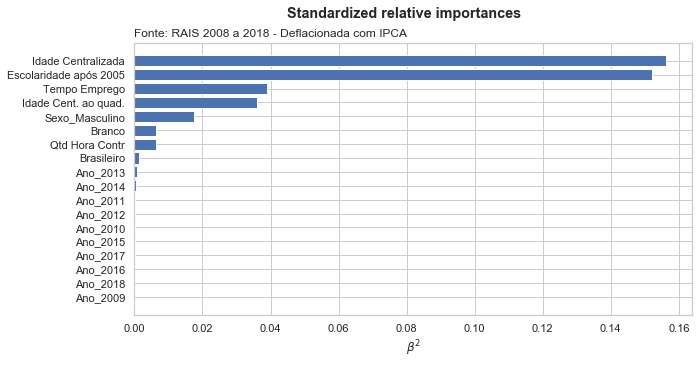

In [15]:
# Comparando coeficientes
bdregpad = pd.DataFrame({'cols':list(regpad.params.keys()), 'betas':regpad.params ** 2}).sort_values('betas',ascending=True)

sns.set(style='whitegrid')

from matplotlib import rc
rc('text', usetex=False)
plt.figure(figsize=(10,5))
plt.barh(bdregpad.cols, bdregpad.betas)
plt.suptitle("Standardized relative importances", fontweight="bold", fontsize="large")
plt.title("Fonte: RAIS 2008 a 2018 - Deflacionada com IPCA", loc='left')
rc('text', usetex=True)
plt.xlabel("$\\beta^2$")
rc('text', usetex=False)
plt.yticks(np.arange(0,18), ['Ano_2009', 'Ano_2018', 'Ano_2016', 'Ano_2017', 'Ano_2015',
                           'Ano_2010', 'Ano_2012', 'Ano_2011', 'Ano_2014', 'Ano_2013',
                           'Brasileiro', 'Qtd Hora Contr', 'Branco',
                           'Sexo_Masculino', 'Idade Cent. ao quad.', 'Tempo Emprego',
                           'Escolaridade após 2005', 'Idade Centralizada'])
plt.show()

---

## Pooled Cross Sectional Regression

### Interação de Ano e Sexo

In [52]:
X.columns

Index(['const', 'Escolaridade após 2005', 'Qtd Hora Contr', 'idadecent',
       'Idade_quad', 'Brasileiro', 'Branco', 'Tempo Emprego',
       'Sexo Trabalhador_Masculino', 'Ano_2009', 'Ano_2010', 'Ano_2011',
       'Ano_2012', 'Ano_2013', 'Ano_2014', 'Ano_2015', 'Ano_2016', 'Ano_2017',
       'Ano_2018'],
      dtype='object')

In [53]:
X_int_anosexo = X.assign(sexoM_2009 = lambda x: x['Sexo Trabalhador_Masculino'] * x.Ano_2009,
                          sexoM_2010= lambda x: x['Sexo Trabalhador_Masculino'] * x.Ano_2010,
                          sexoM_2011= lambda x: x['Sexo Trabalhador_Masculino'] * x.Ano_2011,
                          sexoM_2012= lambda x: x['Sexo Trabalhador_Masculino'] * x.Ano_2012,
                          sexoM_2013= lambda x: x['Sexo Trabalhador_Masculino'] * x.Ano_2013,
                          sexoM_2014= lambda x: x['Sexo Trabalhador_Masculino'] * x.Ano_2014,
                          sexoM_2015= lambda x: x['Sexo Trabalhador_Masculino'] * x.Ano_2015,
                          sexoM_2016= lambda x: x['Sexo Trabalhador_Masculino'] * x.Ano_2016,
                          sexoM_2017= lambda x: x['Sexo Trabalhador_Masculino'] * x.Ano_2017,
                          sexoM_2018= lambda x: x['Sexo Trabalhador_Masculino'] * x.Ano_2018
                         )

In [54]:
reg_int_anosexo = sm.OLS(y, X_int_anosexo).fit()
print(reg_int_anosexo.summary())

                            OLS Regression Results                            
Dep. Variable:           deflacionado   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                 6.374e+04
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        13:43:02   Log-Likelihood:            -2.3038e+06
No. Observations:             2306538   AIC:                         4.608e+06
Df Residuals:                 2306509   BIC:                         4.608e+06
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### Plotando a variação na diferença de salário (medida de desigualdade)

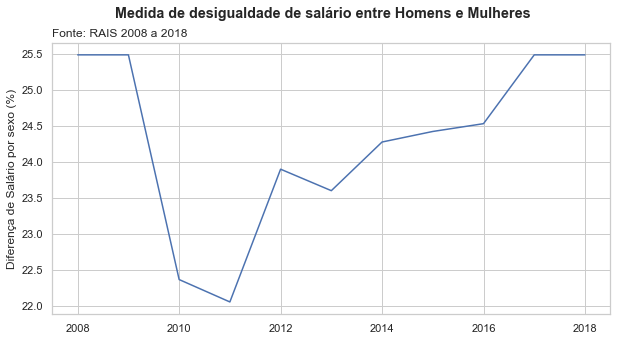

In [55]:
desigualdade = (np.array([reg_int_anosexo.params['Sexo Trabalhador_Masculino'],
               reg_int_anosexo.params['Sexo Trabalhador_Masculino'],
               reg_int_anosexo.params['Sexo Trabalhador_Masculino'] + reg_int_anosexo.params['sexoM_2010'],
               reg_int_anosexo.params['Sexo Trabalhador_Masculino'] + reg_int_anosexo.params['sexoM_2011'],
               reg_int_anosexo.params['Sexo Trabalhador_Masculino'] + reg_int_anosexo.params['sexoM_2012'],
               reg_int_anosexo.params['Sexo Trabalhador_Masculino'] + reg_int_anosexo.params['sexoM_2013'],
               reg_int_anosexo.params['Sexo Trabalhador_Masculino'] + reg_int_anosexo.params['sexoM_2014'],
               reg_int_anosexo.params['Sexo Trabalhador_Masculino'] + reg_int_anosexo.params['sexoM_2015'],
               reg_int_anosexo.params['Sexo Trabalhador_Masculino'] + reg_int_anosexo.params['sexoM_2016'],
               reg_int_anosexo.params['Sexo Trabalhador_Masculino'],
               reg_int_anosexo.params['Sexo Trabalhador_Masculino']]) * 100).round(4)

plt.figure(figsize=(10,5))
plt.plot(np.arange(2008, 2019), desigualdade)
plt.suptitle("Medida de desigualdade de salário entre Homens e Mulheres", fontweight="bold", fontsize="large")
plt.title("Fonte: RAIS 2008 a 2018", loc='left')
plt.ylabel("Diferença de Salário por sexo (%)")
#plt.ylim(21.5, 26)
plt.show()

## Interação Ano * Idade (como *proxy* de Experiência)

In [56]:
X_int_anoidade = Xpad.assign(idade_2009 = lambda x: x['idadecent'] * x.Ano_2009,
                          idade_2010 = lambda x: x['idadecent'] * x.Ano_2010,
                          idade_2011 = lambda x: x['idadecent'] * x.Ano_2011,
                          idade_2012 = lambda x: x['idadecent'] * x.Ano_2012,
                          idade_2013 = lambda x: x['idadecent'] * x.Ano_2013,
                          idade_2014 = lambda x: x['idadecent'] * x.Ano_2014,
                          idade_2015 = lambda x: x['idadecent'] * x.Ano_2015,
                          idade_2016 = lambda x: x['idadecent'] * x.Ano_2016,
                          idade_2017 = lambda x: x['idadecent'] * x.Ano_2017,
                          idade_2018 = lambda x: x['idadecent'] * x.Ano_2018
                         )

In [57]:
reg_int_anoidade = sm.OLS(ypad, X_int_anoidade).fit()
print(reg_int_anoidade.summary())

                                 OLS Regression Results                                
Dep. Variable:           deflacionado   R-squared (uncentered):                   0.437
Model:                            OLS   Adj. R-squared (uncentered):              0.437
Method:                 Least Squares   F-statistic:                          6.403e+04
Date:                Wed, 26 Feb 2020   Prob (F-statistic):                        0.00
Time:                        13:44:16   Log-Likelihood:                     -2.6096e+06
No. Observations:             2306538   AIC:                                  5.219e+06
Df Residuals:                 2306510   BIC:                                  5.220e+06
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

### Plotando a variação no efeito da Experiência

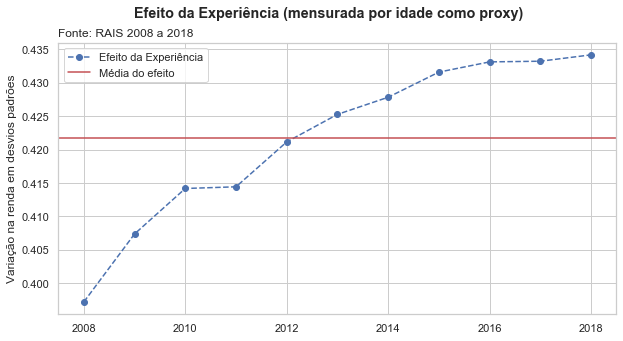

In [70]:
efeito_idade = (np.array([reg_int_anoidade.params['idadecent'],
                           reg_int_anoidade.params['idadecent'] + reg_int_anoidade.params['idade_2009'],
                           reg_int_anoidade.params['idadecent'] + reg_int_anoidade.params['idade_2010'],
                           reg_int_anoidade.params['idadecent'] + reg_int_anoidade.params['idade_2011'],
                           reg_int_anoidade.params['idadecent'] + reg_int_anoidade.params['idade_2012'],
                           reg_int_anoidade.params['idadecent'] + reg_int_anoidade.params['idade_2013'],
                           reg_int_anoidade.params['idadecent'] + reg_int_anoidade.params['idade_2014'],
                           reg_int_anoidade.params['idadecent'] + reg_int_anoidade.params['idade_2015'],
                           reg_int_anoidade.params['idadecent'] + reg_int_anoidade.params['idade_2016'],
                           reg_int_anoidade.params['idadecent'] + reg_int_anoidade.params['idade_2017'],
                           reg_int_anoidade.params['idadecent'] + reg_int_anoidade.params['idade_2018'],
                         ]))

plt.figure(figsize=(10,5))
plt.plot(np.arange(2008, 2019), efeito_idade, linestyle='--', marker='o', label='Efeito da Experiência')
plt.axhline(np.mean(efeito_idade), c='r', label='Média do efeito')
plt.suptitle("Efeito da Experiência (mensurada por idade como proxy)", fontweight="bold", fontsize="large")
plt.title("Fonte: RAIS 2008 a 2018", loc='left')
plt.ylabel("Variação na renda em desvios padrões")
plt.legend()
plt.show()

## Interação Ano * Escolaridade

In [65]:
X_int_anoesco = Xpad.assign(esco_2009 = lambda x: x['Escolaridade após 2005'] * x.Ano_2009,
                          esco_2010 = lambda x: x['Escolaridade após 2005'] * x.Ano_2010,
                          esco_2011 = lambda x: x['Escolaridade após 2005'] * x.Ano_2011,
                          esco_2012 = lambda x: x['Escolaridade após 2005'] * x.Ano_2012,
                          esco_2013 = lambda x: x['Escolaridade após 2005'] * x.Ano_2013,
                          esco_2014 = lambda x: x['Escolaridade após 2005'] * x.Ano_2014,
                          esco_2015 = lambda x: x['Escolaridade após 2005'] * x.Ano_2015,
                          esco_2016 = lambda x: x['Escolaridade após 2005'] * x.Ano_2016,
                          esco_2017 = lambda x: x['Escolaridade após 2005'] * x.Ano_2017,
                          esco_2018 = lambda x: x['Escolaridade após 2005'] * x.Ano_2018
                         )

In [66]:
reg_int_anoesco = sm.OLS(ypad, X_int_anoesco).fit()
print(reg_int_anoesco.summary())

                                 OLS Regression Results                                
Dep. Variable:           deflacionado   R-squared (uncentered):                   0.437
Model:                            OLS   Adj. R-squared (uncentered):              0.437
Method:                 Least Squares   F-statistic:                          6.385e+04
Date:                Wed, 26 Feb 2020   Prob (F-statistic):                        0.00
Time:                        13:47:51   Log-Likelihood:                     -2.6110e+06
No. Observations:             2306538   AIC:                                  5.222e+06
Df Residuals:                 2306510   BIC:                                  5.222e+06
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

### Plotando a variação no efeito da Escolaridade

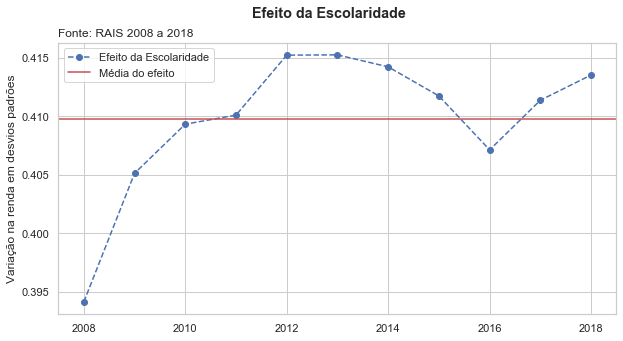

In [69]:
efeito_esco = (np.array([reg_int_anoesco.params['Escolaridade após 2005'],
                           reg_int_anoesco.params['Escolaridade após 2005'] + reg_int_anoesco.params['esco_2009'],
                           reg_int_anoesco.params['Escolaridade após 2005'] + reg_int_anoesco.params['esco_2010'],
                           reg_int_anoesco.params['Escolaridade após 2005'] + reg_int_anoesco.params['esco_2011'],
                           reg_int_anoesco.params['Escolaridade após 2005'] + reg_int_anoesco.params['esco_2012'],
                           reg_int_anoesco.params['Escolaridade após 2005'] + reg_int_anoesco.params['esco_2013'],
                           reg_int_anoesco.params['Escolaridade após 2005'] + reg_int_anoesco.params['esco_2014'],
                           reg_int_anoesco.params['Escolaridade após 2005'] + reg_int_anoesco.params['esco_2015'],
                           reg_int_anoesco.params['Escolaridade após 2005'] + reg_int_anoesco.params['esco_2016'],
                           reg_int_anoesco.params['Escolaridade após 2005'] + reg_int_anoesco.params['esco_2017'],
                           reg_int_anoesco.params['Escolaridade após 2005'] + reg_int_anoesco.params['esco_2018'],
                         ]))

plt.figure(figsize=(10,5))
plt.plot(np.arange(2008, 2019), efeito_esco, linestyle='--', marker='o', label='Efeito da Escolaridade')
plt.axhline(np.mean(efeito_esco), c='r', label='Média do efeito')
plt.suptitle("Efeito da Escolaridade", fontweight="bold", fontsize="large")
plt.title("Fonte: RAIS 2008 a 2018", loc='left')
plt.ylabel("Variação na renda em desvios padrões")
plt.legend()
plt.show()

---

# Apresentando os efeitos interativos de Escolaridade e Idade

In [ ]:
"""idadeesco = Xpad.assign(esco_2009 = lambda x: x['Escolaridade após 2005'] * x.Ano_2009,
                          esco_2010 = lambda x: x['Escolaridade após 2005'] * x.Ano_2010,
                          esco_2011 = lambda x: x['Escolaridade após 2005'] * x.Ano_2011,
                          esco_2012 = lambda x: x['Escolaridade após 2005'] * x.Ano_2012,
                          esco_2013 = lambda x: x['Escolaridade após 2005'] * x.Ano_2013,
                          esco_2014 = lambda x: x['Escolaridade após 2005'] * x.Ano_2014,
                          esco_2015 = lambda x: x['Escolaridade após 2005'] * x.Ano_2015,
                          esco_2016 = lambda x: x['Escolaridade após 2005'] * x.Ano_2016,
                          esco_2017 = lambda x: x['Escolaridade após 2005'] * x.Ano_2017,
                          esco_2018 = lambda x: x['Escolaridade após 2005'] * x.Ano_2018,
                        idade_2009 = lambda x: x['idadecent'] * x.Ano_2009,
                          idade_2010 = lambda x: x['idadecent'] * x.Ano_2010,
                          idade_2011 = lambda x: x['idadecent'] * x.Ano_2011,
                          idade_2012 = lambda x: x['idadecent'] * x.Ano_2012,
                          idade_2013 = lambda x: x['idadecent'] * x.Ano_2013,
                          idade_2014 = lambda x: x['idadecent'] * x.Ano_2014,
                          idade_2015 = lambda x: x['idadecent'] * x.Ano_2015,
                          idade_2016 = lambda x: x['idadecent'] * x.Ano_2016,
                          idade_2017 = lambda x: x['idadecent'] * x.Ano_2017,
                          idade_2018 = lambda x: x['idadecent'] * x.Ano_2018
                         )
"""

In [ ]:
"""
reg_int_idadeescopad = sm.OLS(y, idadeesco).fit()
print(reg_int_idadeescopad.summary())
"""

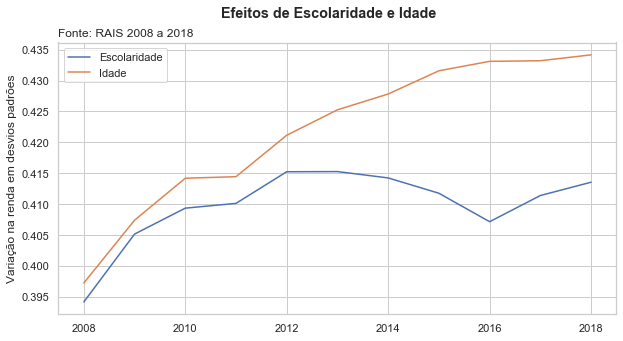

In [101]:
"""efeito_escopad = (np.array([reg_int_idadeescopad.params['Escolaridade após 2005'],
                           reg_int_idadeescopad.params['Escolaridade após 2005'] + reg_int_idadeescopad.params['esco_2009'],
                           reg_int_idadeescopad.params['Escolaridade após 2005'] + reg_int_idadeescopad.params['esco_2010'],
                           reg_int_idadeescopad.params['Escolaridade após 2005'] + reg_int_idadeescopad.params['esco_2011'],
                           reg_int_idadeescopad.params['Escolaridade após 2005'] + reg_int_idadeescopad.params['esco_2012'],
                           reg_int_idadeescopad.params['Escolaridade após 2005'] + reg_int_idadeescopad.params['esco_2013'],
                           reg_int_idadeescopad.params['Escolaridade após 2005'] + reg_int_idadeescopad.params['esco_2014'],
                           reg_int_idadeescopad.params['Escolaridade após 2005'] + reg_int_idadeescopad.params['esco_2015'],
                           reg_int_idadeescopad.params['Escolaridade após 2005'] + reg_int_idadeescopad.params['esco_2016'],
                           reg_int_idadeescopad.params['Escolaridade após 2005'] + reg_int_idadeescopad.params['esco_2017'],
                           reg_int_idadeescopad.params['Escolaridade após 2005'] + reg_int_idadeescopad.params['esco_2018'],
                         ])).round(6)

efeito_idadepad = (np.array([reg_int_idadeescopad.params['idadecent'],
                           reg_int_idadeescopad.params['idadecent'] + reg_int_idadeescopad.params['idade_2009'],
                           reg_int_idadeescopad.params['idadecent'] + reg_int_idadeescopad.params['idade_2010'],
                           reg_int_idadeescopad.params['idadecent'] + reg_int_idadeescopad.params['idade_2011'],
                           reg_int_idadeescopad.params['idadecent'] + reg_int_idadeescopad.params['idade_2012'],
                           reg_int_idadeescopad.params['idadecent'] + reg_int_idadeescopad.params['idade_2013'],
                           reg_int_idadeescopad.params['idadecent'] + reg_int_idadeescopad.params['idade_2014'],
                           reg_int_idadeescopad.params['idadecent'] + reg_int_idadeescopad.params['idade_2015'],
                           reg_int_idadeescopad.params['idadecent'] + reg_int_idadeescopad.params['idade_2016'],
                           reg_int_idadeescopad.params['idadecent'] + reg_int_idadeescopad.params['idade_2017'],
                           reg_int_idadeescopad.params['idadecent'] + reg_int_idadeescopad.params['idade_2018'],
                         ])).round(6)
"""

plt.figure(figsize=(10,5))
plt.plot(np.arange(2008, 2019), efeito_esco, label = "Escolaridade")
plt.plot(np.arange(2008, 2019), efeito_idade, label = "Idade")
plt.suptitle("Efeitos de Escolaridade e Idade", fontweight="bold", fontsize="large")
plt.title("Fonte: RAIS 2008 a 2018", loc='left')
plt.ylabel("Variação na renda em desvios padrões")
plt.legend()
plt.show()

In [117]:
from statsmodels.iolib.summary2 import summary_col
dfoutput = summary_col([reg_int_anosexo,reg_int_anoidade,reg_int_anoesco],stars=True)
print(dfoutput)


                           deflacionado I deflacionado II deflacionado III
--------------------------------------------------------------------------
Ano_2009                   0.0029         0.0038***       0.0082***       
                           (0.0039)       (0.0007)        (0.0007)        
Ano_2010                   -0.0116***     -0.0070***      -0.0017**       
                           (0.0038)       (0.0007)        (0.0007)        
Ano_2011                   0.0619***      0.0153***       0.0209***       
                           (0.0037)       (0.0007)        (0.0008)        
Ano_2012                   0.0451***      0.0156***       0.0213***       
                           (0.0036)       (0.0008)        (0.0008)        
Ano_2013                   0.0842***      0.0289***       0.0335***       
                           (0.0036)       (0.0008)        (0.0008)        
Ano_2014                   0.0702***      0.0259***       0.0306***       
                        

In [16]:
# Regressão para 2018
X2018 = pd.get_dummies(sud.loc[sud.Ano == 2018,:][['Sexo Trabalhador',
                       'Escolaridade após 2005', 
                       'Qtd Hora Contr', 
                       'idadecent', 'Idade_quad', 
                       'Brasileiro', 
                       'Branco', 
                       'Tempo Emprego'
                      ]],
                  drop_first=True).apply(stats.zscore)

y2018 = pd.DataFrame(np.log(salarios.loc[salarios.Ano == '2018-11-01','deflacionado']))[['deflacionado']].apply(stats.zscore).values

In [17]:
reg2018 = sm.OLS(y2018, X2018).fit()
print(reg2018.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.408
Model:                            OLS   Adj. R-squared (uncentered):              0.408
Method:                 Least Squares   F-statistic:                          2.119e+04
Date:                Wed, 26 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:09   Log-Likelihood:                     -2.8506e+05
No. Observations:              246355   AIC:                                  5.701e+05
Df Residuals:                  246347   BIC:                                  5.702e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

---

## Testar

- termo interativo entre sexo e branco
- termo interativo entre sexo e escolaridade
- termo interativo entre sexo e idade (análise do efeito senioridade)

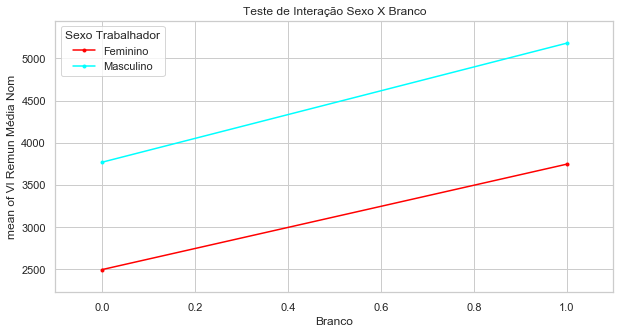

In [97]:
fig, ax = plt.subplots(figsize=(10,5))
interaction_plot(sud['Branco'], sud["Sexo Trabalhador"], sud["Vl Remun Média Nom"], ax=ax)
plt.title("Teste de Interação Sexo X Branco")
plt.show()

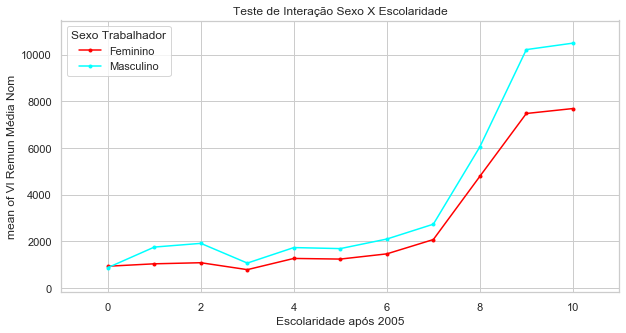

In [77]:
fig, ax = plt.subplots(figsize=(10,5))
interaction_plot(sud["Escolaridade após 2005"], sud["Sexo Trabalhador"], sud["Vl Remun Média Nom"], ax=ax)
plt.title("Teste de Interação Sexo X Escolaridade")
plt.show()

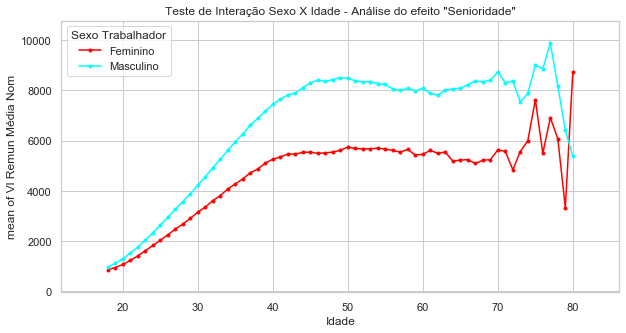

In [126]:
fig, ax = plt.subplots(figsize=(10,5))
interaction_plot(sud.Idade, sud["Sexo Trabalhador"], sud["Vl Remun Média Nom"], ax=ax)
plt.title('Teste de Interação Sexo X Idade - Análise do efeito "Senioridade"')
plt.show()

---

## Análise de resíduos

(array([1.150000e+02, 1.396000e+03, 3.718800e+04, 4.803340e+05,
        1.077791e+06, 6.004200e+05, 9.916600e+04, 9.390000e+03,
        6.990000e+02, 3.900000e+01]),
 array([-4.27290438, -3.34749562, -2.42208685, -1.49667809, -0.57126933,
         0.35413943,  1.2795482 ,  2.20495696,  3.13036572,  4.05577449,
         4.98118325]),
 <a list of 10 Patch objects>)

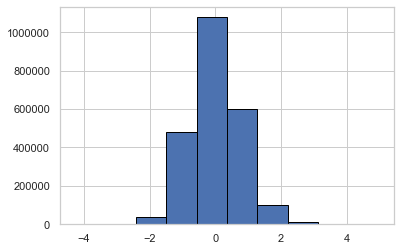

In [125]:
plt.hist(regpad.resid, edgecolor="black")

LinregressResult(slope=-3.487930297003333e-13, intercept=9.413203800706553e-16, rvalue=-3.068025720820404e-13, pvalue=0.9999999996282259, stderr=0.0007485635610403669)


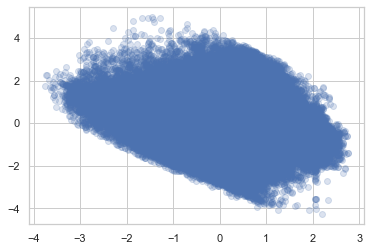

In [126]:
yhat = regpad.predict()
from scipy.stats import linregress
print(linregress(yhat, regpad.resid))
plt.scatter(yhat, regpad.resid, alpha=.2)
plt.show()

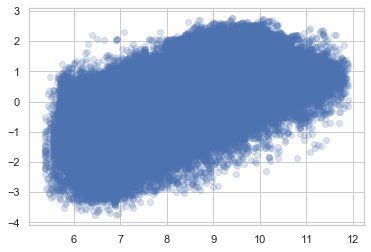

In [128]:
plt.scatter(y, yhat, alpha=.2)
#plt.xlim((5, 12))
#plt.ylim((5, 12))

---

# Modelo Hierárquico

In [18]:
Xmixed = sud[['Sexo Trabalhador',
               'Escolaridade após 2005', 
               'Qtd Hora Contr', 
               'idadecent', 'Idade_quad', 
               'Brasileiro', 
               'Branco', 
               'Tempo Emprego',
               'Ano'
              ]]
Xmixed.columns = ['sexo', 'esco', 'qtd_hr_cont',
                  'idadecent', 'idade_quad', 'brasileiro', 'branco', 
                  'tempo_emprego', 'ano']
bdmixed = pd.concat([Xmixed, y], axis=1)
bdmixed

,sexo,esco,qtd_hr_cont,idadecent,idade_quad,brasileiro,branco,tempo_emprego,ano,deflacionado
0,Masculino,1.0,44.0,-11.583958,134.188080,1,0,4.7,2008,7.734660
1,Masculino,1.0,44.0,-9.583958,91.852248,1,0,2.3,2008,7.685339
2,Masculino,2.0,44.0,1.416042,2.005175,1,0,77.9,2008,8.113305
3,Masculino,3.0,44.0,17.416042,303.318524,1,0,0.3,2008,9.508792
4,Masculino,4.0,44.0,16.416042,269.486439,1,1,0.1,2008,7.545086
...,...,...,...,...,...,...,...,...,...,...
2306533,Feminino,10.0,40.0,21.416042,458.646861,1,1,8.9,2017,9.284459
2306534,Feminino,10.0,40.0,8.416042,70.829765,1,0,5.9,2017,8.025270
2306535,Feminino,10.0,40.0,2.416042,5.837260,1,1,23.6,2017,8.837602
2306536,Feminino,10.0,40.0,-0.583958,0.341007,0,1,6.3,2017,7.129497


In [131]:
vc_formula = {'esco': '0 + esco', 'idadecent': '0 + idadecent'}
md = smf.mixedlm("deflacionado ~ sexo + esco + qtd_hr_cont + idadecent + idade_quad + brasileiro + branco + tempo_emprego", 
                 bdmixed, groups=bdmixed["ano"], re_formula="1", vc_formula=vc_formula, use_sqrt=False)
mdf = md.fit(reml=False)
print(mdf.summary())

C:\Users\Neylson\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable: deflacionado 
No. Observations:   2306538  Method:             ML           
No. Groups:         11       Scale:              0.4305       
Min. group size:    145692   Likelihood:         -2301050.7425
Max. group size:    246355   Converged:          Yes          
Mean group size:    209685.3                                  
--------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          5.393    0.198   27.242 0.000  5.005  5.781
sexo[T.Masculino]  0.241    0.001  263.576 0.000  0.239  0.243
esco               0.322    0.198    1.626 0.104 -0.066  0.709
qtd_hr_cont        0.014    0.000  151.905 0.000  0.014  0.015
idadecent          0.036    0.198    0.181 0.856 -0.352  0.424
idade_quad        -0.001    0.000 -295.117 0.000 -0.001 -0.001
brasi

In [132]:
u_esco = []
u_idadecent = []
u_intercept = []
for i in np.arange(2008, 2019):
    u_intercept.append(mdf.random_effects[i][0])
    u_esco.append(mdf.random_effects[i][1])
    u_idadecent.append(mdf.random_effects[i][2])
    print(i, "\n", mdf.random_effects[i], end='\n\n')

2008 
 Group                   0.223726
esco[esco]             -0.036897
idadecent[idadecent]   -0.006721
dtype: float64

2009 
 Group                   0.011565
esco[esco]             -0.003267
idadecent[idadecent]   -0.003798
dtype: float64

2010 
 Group                  -0.079348
esco[esco]              0.004354
idadecent[idadecent]   -0.001959
dtype: float64

2011 
 Group                  -0.017220
esco[esco]              0.005602
idadecent[idadecent]   -0.002075
dtype: float64

2012 
 Group                  -0.086670
esco[esco]              0.014843
idadecent[idadecent]   -0.000588
dtype: float64

2013 
 Group                  -0.036635
esco[esco]              0.012957
idadecent[idadecent]    0.000688
dtype: float64

2014 
 Group                  -0.014397
esco[esco]              0.008581
idadecent[idadecent]    0.001414
dtype: float64

2015 
 Group                   0.001540
esco[esco]              0.000753
idadecent[idadecent]    0.002668
dtype: float64

2016 
 Group            

In [133]:
variacao_esco = np.array(u_esco) + mdf.params['esco']
variacao_idade = np.array(u_idadecent) + mdf.params['idadecent']

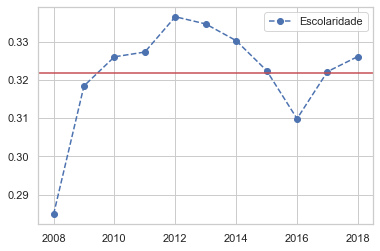

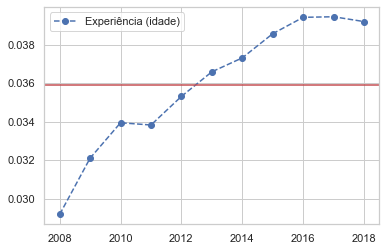

In [134]:
plt.plot(np.arange(2008, 2019), variacao_esco, label='Escolaridade', linestyle='--', marker='o')
plt.axhline(mdf.params['esco'], c='r', linestyle='-')
plt.legend()
plt.show()

plt.plot(np.arange(2008, 2019), variacao_idade, label='Experiência (idade)', linestyle='--', marker='o')
plt.axhline(mdf.params['idadecent'], c='r', linestyle='-')
plt.legend()
plt.show()


In [135]:
randfx = []
for key, value in mdf.random_effects.items():
    randfx.append(mdf.random_effects[key].values[0])
    print(key, ":", mdf.random_effects[key].values[0])

2008 : 0.22372592334569194
2009 : 0.011565232654321777
2010 : -0.07934821306848218
2011 : -0.017219996560578425
2012 : -0.08666981004812058
2013 : -0.036634957134243674
2014 : -0.014397146054999248
2015 : 0.0015401008465721307
2016 : 0.05998862057979994
2017 : -0.0009097525833937511
2018 : -0.06163999748769866


In [136]:
randfx = np.array(randfx) + mdf.params[0]
randfx

array([5.61650963, 5.40434894, 5.31343549, 5.37556371, 5.3061139 ,
       5.35614875, 5.37838656, 5.39432381, 5.45277233, 5.39187395,
       5.33114371])

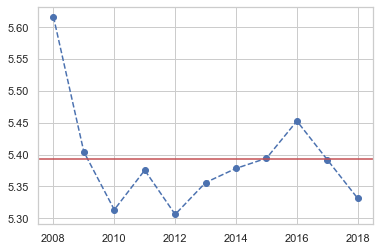

In [137]:
plt.plot(np.arange(2008, 2019), u_intercept + mdf.params[0], linestyle='--', marker='o')
plt.axhline(y=mdf.params[0], c='r', linestyle='-')
